MAML伪代码

\begin{aligned}
    &\rule{110mm}{0.4pt}                                                                 \\
    &\text{Algorithm2  MAML for Few-Shot Supervised Learning}\\
    &\rule{110mm}{0.4pt}                                                                 \\
    &\textbf{Require: } p(\mathcal{T}): \text{distribution over tasks}\\
    &\textbf{Require: } \alpha \text{: 一系列task训练-supportSet，梯度更新学习率-在循环内更新} \\ 
    &\hspace{17mm} \beta \text{: 一系列task评估-querySet，梯度更新学习率-在循环外更新}\\
    &\rule{110mm}{0.4pt}                                                                 \\
    &\text{ 1: 初始化参数 } \theta \\
    &\text{ 2: }\textbf{while }\text{not done }\textbf{do }\\
    &\text{ 3: }\hspace{5mm}\text{从任务集合中抽取任务 }\mathcal{T}_i \sim  p(\mathcal{T}) \\
    &\text{ 4: }\hspace{5mm}\textbf{for all }\mathcal{T}_i\textbf{ do }\\
    &\text{ 5: }\hspace{10mm}\text{从任务中抽取k-shot个样本} \mathcal{D}=\{X^j, Y^j\} \in \mathcal{T}_i\\
    &\text{ 6: }\hspace{10mm}\text{基于任务的损失函数计算损失} \mathcal{L}_{\mathcal{T}_i}=l(Y^j, f_{\theta_{i}}(X^j))\\
    &\text{ 7: }\hspace{10mm}\text{基于损失函数计算梯度, 并更新参数} \frac{\partial{\mathcal{L}_{\mathcal{T}_i}}}{\partial \theta_i} = \nabla_\theta \mathcal{L}_{\mathcal{T}_i}(f_\theta) \\
    &\hspace{17mm} \theta_i^{\prime} = \theta - \alpha \nabla_\theta \mathcal{L}_{\mathcal{T}_i}(f_\theta) \\
    &\text{ 8: }\hspace{10mm}\text{从任务中抽取q-query个样本} \mathcal{D}^{\prime}=\{X^j, Y^j\} \in \mathcal{T}_i\\
    &\hspace{15mm} \text{基于更新后的}\theta^{\prime}\text{进行预测并计算损失，用于循环后更新} \mathcal{L}^{\prime}_{\mathcal{T}_i}=l(Y^j, f_{\theta^{\prime}_{i}}(X^j))\\
    &\hspace{15mm} \text{计算梯度}\frac{\partial{\mathcal{L}^{\prime}_{\mathcal{T}_i}}}{\partial \theta^{\prime}_i} = \nabla_\theta \mathcal{L}^{\prime}_{\mathcal{T}_i}(f_{\theta^{\prime}}) \\
    &\hspace{15mm} \text{计算最终梯度} \nabla_\theta \mathcal{L}_{\mathcal{T}_i}(f_{\theta^{\prime}})  = \frac{\partial{\mathcal{L}^{\prime}_{\mathcal{T}_i}}}{\partial \theta_i}=\frac{\partial{\mathcal{L}^{\prime}_{\mathcal{T}_i}}}{\partial \theta^{\prime}_i}\frac{\partial \theta^{\prime}_i}{\partial \theta_i} \\
    &\text{ 9: }\hspace{5mm}\textbf{end for}  \\
    &\text{10: }\hspace{5mm}\text{Update } \theta \leftarrow \theta - \beta \sum_{\mathcal{T}_i \sim p(\mathcal{T})} \nabla_\theta \mathcal{L}_{\mathcal{T}_i}(f_{\theta^{\prime}})  \\
    &\text{11: }\textbf{end while } \\
    &\bf{return} \:  \theta                                                     \\[-1.ex]
    &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
\end{aligned}



In [12]:
import numpy as np 
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F
import random
from tqdm.auto import tqdm
from collections import OrderedDict
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


def all_seed(seed=6666):
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

all_seed(0)

Set env random_seed = 0


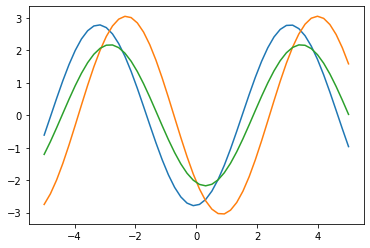

In [13]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(1, 2 * np.pi)
        self.train_x = None
    
    def f(self, x):
        return self.a * np.sin(x + self.b)
    
    def train_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        
        y = self.f(x)
        return torch.Tensor(x).float(), torch.Tensor(y).float()
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x).float(), torch.Tensor(y).float()
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set()
        return plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy(), *args, **kwargs)


SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

In [14]:

class sineModel(nn.Module):
    def __init__(self):
        super(sineModel, self).__init__()
        self.l1 = nn.Linear(1, 40)
        self.l2 = nn.Linear(40, 40)
        self.head = nn.Linear(40, 1)
    
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return self.head(x)
    
    def query_forward(self, x, support_param_dict):
        x = torch.relu(
            F.linear(x, support_param_dict['l1.weight'], support_param_dict['l1.bias'])
            )
        x = torch.relu(
            F.linear(x, support_param_dict['l2.weight'], support_param_dict['l2.bias'])
            )
        return F.linear(x, support_param_dict['head.weight'], support_param_dict['head.bias'])



SUPPORT_QUERY_TASKS = [SineWaveTask() for _ in range(1000)]
TEST_TASKS = [SineWaveTask() for _ in range(1000)]

# MAML

In [8]:
def maml_sine(model, epochs, lr=1e-3, inner_lr=0.1, batch_size=1, first_order=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    ep_loss = []
    for ep_i in range(epochs):
        tqd_bar = tqdm(
            enumerate(random.sample(SUPPORT_QUERY_TASKS, len(SUPPORT_QUERY_TASKS))),
            total=len(SUPPORT_QUERY_TASKS)
        )
        tqd_bar.set_description(f'[ {ep_i+1:02d} / {epochs:02d} ]')
        task_loss = []
        for idx, suport_t in tqd_bar:
            fast_weights = OrderedDict(model.named_parameters())
            s_x, s_y = suport_t.train_set(force_new=False)
            q_x, q_y = suport_t.train_set(force_new=True)
            # support
            for _ in range(1): 
                s_y_hat = model(torch.Tensor(s_x[:, None]))
                loss = loss_fn(s_y_hat, torch.Tensor(s_y.reshape(-1, 1)))
                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=not first_order) # 便于进行二阶导
                fast_weights = OrderedDict(
                    (name, param - inner_lr * (grad.detach().data if first_order else grad) )
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )
            
            # query
            logits = model.query_forward(torch.Tensor(q_x[:, None]), fast_weights)
            loss = loss_fn(logits, torch.Tensor(q_y.reshape(-1, 1)))
            task_loss.append(loss)
            
            if (idx + 1) % batch_size == 0:
                # update
                model.train()
                opt.zero_grad()
                meta_batch_loss = torch.stack(task_loss).mean()
                meta_batch_loss.backward()
                opt.step()
                loss_item = meta_batch_loss.cpu().detach().numpy()
                tqd_bar.set_postfix({'loss': "{:.3f}".format(loss_item)})
                task_loss = []

        ep_loss.append(loss_item)
    return ep_loss


sine_model = sineModel()
ep_losses = maml_sine(sine_model, epochs=5, lr=1e-3, inner_lr=0.02, batch_size=2, first_order=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

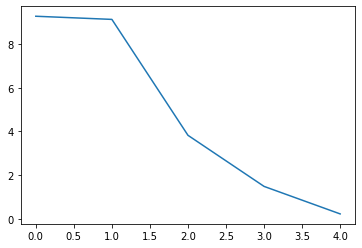

In [9]:
# 3.946 0.471 1.892 5.098
# 2.672 0.966 1.767 4.566
plt.plot(ep_losses)
plt.show()

# Test

In [15]:

def eval_sine_test(model, test, update_times_list=[0, 1, 10], lr=0.01):
    model_copy = sineModel()
    model_copy.load_state_dict(model.state_dict())
    opt = torch.optim.Adam(model_copy.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    x_te, y_te = test.test_set()
    x_tr, y_tr = test.train_set()
    
    fit_res = []
    for i in update_times_list:
        if i == 0:
            res = model_copy(torch.Tensor(x_te[:, None]))
            loss = loss_fn(res, torch.Tensor(y_te.reshape(-1, 1)))
            fit_res.append((i, res.cpu().detach().numpy(), loss.cpu().detach().numpy()))
            continue
        
        for j in range(i):
            opt.zero_grad()
            res = model_copy(torch.Tensor(x_tr[:, None]))
            loss = loss_fn(res, torch.Tensor(y_tr.reshape(-1, 1)))
            loss.backward()
            opt.step()
        
        res = model_copy(torch.Tensor(x_te[:, None]))
        loss = loss_fn(res, torch.Tensor(y_te.reshape(-1, 1)))
        fit_res.append((i, res.cpu().detach().numpy(), loss.cpu().detach().numpy()))
    return fit_res


def plot_sine_test(model, test, update_times_list=[0, 1, 10], lr=0.01):
    x_test, y_test = test.test_set()
    x_train, y_train = test.train_set()
    
    fit_res = eval_sine_test(model, test, update_times_list, lr)
    train = plt.scatter(x_train.numpy().flatten(), y_train.numpy().flatten(), marker='^')
    truth = plt.plot(x_test.numpy().flatten(), y_test.numpy().flatten())
    plots = [train, truth]
    legend = ['Training Point', 'True Function']
    for n, res, loss in fit_res:
        cur = plt.plot(x_test.numpy(), res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    
    plt.legend(legend)
    
    

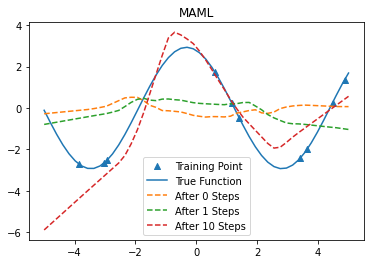

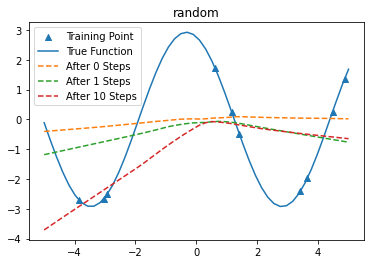

In [16]:
# np.random.uniform(-5, 5, size=20)
plot_sine_test(sine_model, TEST_TASKS[0], update_times_list=[0, 1, 10], lr=0.01)
plt.title('MAML')
plt.show()

plot_sine_test(sineModel(), TEST_TASKS[0], update_times_list=[0, 1, 10], lr=0.01)
plt.title('random')
plt.show()